<div style="display:block">
    <div style="width: 20%; display: inline-block; text-align: left;">
    </div>
    <div style="width: 59%; display: inline-block">
        <h1  style="text-align: center">ML Part 2: Image classification with neural networks <span class="tocSkip"></span></h1>
        <div style="width: 90%; text-align: center; display: inline-block;"><i><strong>Author:</i> Adithya Murali, Sameer Khan <span class="tocSkip"></span></strong> </div>
        
    
</div>

**Group Members:** 

Adithya Murali (Eid: am233329)

Sameer Khan (Eid: sak4225)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Data transformation and loading
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load and split the dataset
dataset = ImageFolder(root='EuroSAT_RGB', transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Neural Network Model 1

In [3]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 11)  # 11 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and move the model to the specified device
model = CNN().to(device)


In [4]:

# Set up the optimizer and loss function 
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Training loop for the model
for epoch in range(10):  # Train for 10 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()


In [5]:
# Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions and true labels for later analysis
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100:.2f}%')


Overall Test-Set Accuracy: 83.35%


Neural Network Model Test-Set Accuracy is 83.35%.

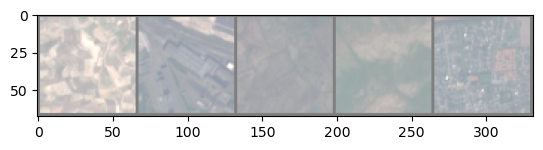

Predicted:  PermanentCrop  Highway  HerbaceousVegetation  AnnualCrop  Residential 
Actual:     PermanentCrop  Industrial  Pasture  HerbaceousVegetation  Residential 


In [11]:
import random

# List of classes from the dataset
classes = dataset.classes

# Function to display an image
def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()



# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))



# Pass the images through the model to get outputs
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images back to the CPU for displaying
images_cpu = images.cpu()

# Select a random subset of images to display
num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Extract the random images and their corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Display the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the selected images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the selected images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))


PermanentCrop and Residential predicted correctly.

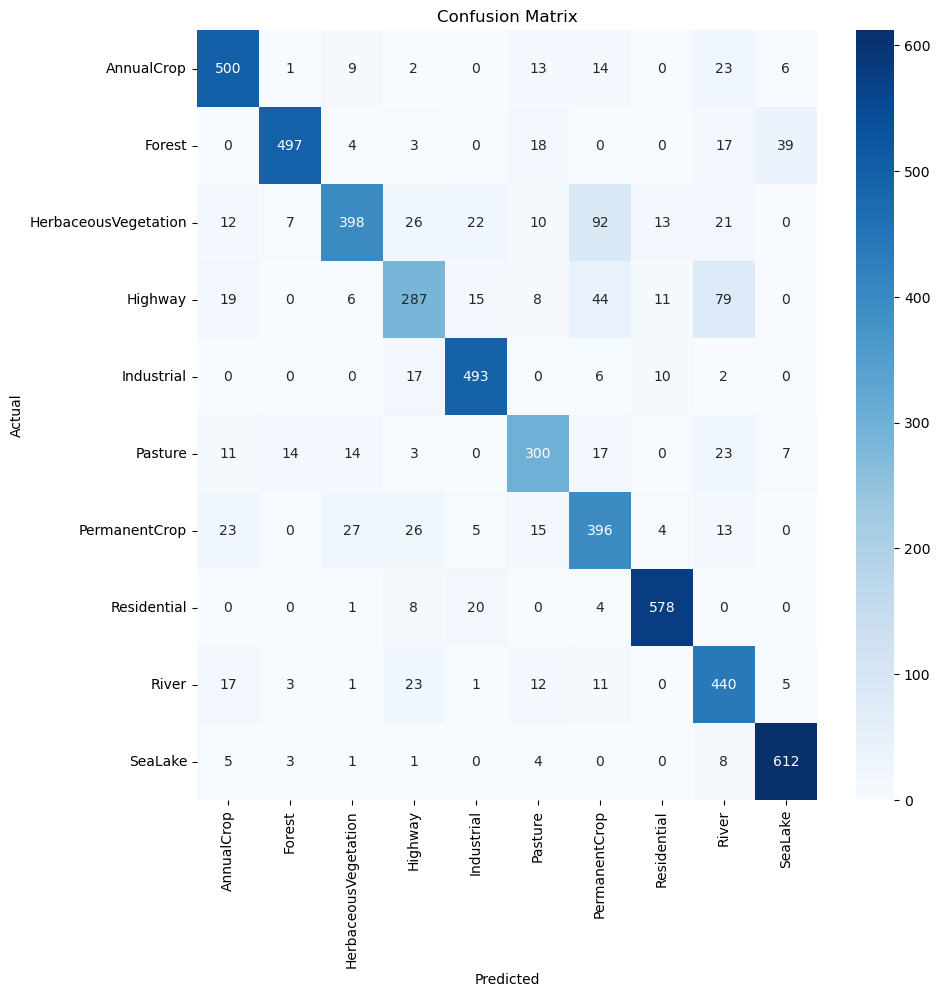

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The Neural Network makes mistakes between:  
- PermanentCrop and HerbaceousVegetation  
- PermanentCrop and Highway  
- River and Highway  
- SeaLake and Forest  


Neural Network Model with more layers

In [13]:

# Data transformation and loading
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset with transformations
dataset = ImageFolder(root='EuroSAT_RGB', transform=data_transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Neural Network Model 2

In [14]:

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 11)  # 11 output classes
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Forward pass through the convolutional and pooling layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 8 * 8)
        
        # Forward pass through the fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [15]:

# Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Training loop for the model
for epoch in range(10):  # Train for 10 epochs
    for images, labels in train_loader:
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()


In [16]:

# Evaluate the model
correct = 0
total = 0
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions by selecting the class with the highest score
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions and true labels for later analysis
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100:.2f}%')


Overall Test-Set Accuracy: 80.35%


Neural Network Model 2 Test-Set Accuracy is 80.35%.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


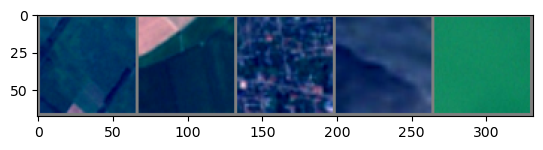

Predicted:  AnnualCrop  AnnualCrop  Residential  HerbaceousVegetation  SeaLake 
Actual:     Pasture  AnnualCrop  Residential  HerbaceousVegetation  SeaLake 


In [17]:

# List of classes from the dataset
classes = dataset.classes

# Function to display an image
def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()



# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))



# Pass the images through the model to get outputs
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images back to the CPU for displaying
images_cpu = images.cpu()

# Select a random subset of images to display
num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Extract the random images and their corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Display the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the selected images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the selected images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))


AnnualCrop, Residential, HerbaceousVegetation, and SeaLake predicted correctly.

ResNet18

In [18]:

# Define data transformations with random augmentations and normalization
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the EuroSAT RGB dataset with the defined transformations
dataset = ImageFolder(root='EuroSAT_RGB', transform=data_transform)

# Split the dataset into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [19]:
from torchvision import models

Neural Network Model 3 using ResNet18

In [20]:

# Define the CNN model using ResNet-18 architecture
model = models.resnet18(weights=None)

# Modify the final fully connected layer to match the number of classes (11 classes)
model.fc = nn.Linear(model.fc.in_features, 11)

# Determine the device (GPU if available, else CPU) and move the model to the selected device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [21]:

# Set the number of epochs for training
num_epochs = 20

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Training loop for the model
for epoch in range(num_epochs):  # Train for 20 epochs
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate the running loss
        running_loss += loss.item()
        
        # Print the running loss every 100 mini-batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Mini-batch {i + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0


Epoch 1, Mini-batch 100, Loss: 1.3537
Epoch 1, Mini-batch 200, Loss: 1.1140
Epoch 1, Mini-batch 300, Loss: 0.9949
Epoch 2, Mini-batch 100, Loss: 0.8554
Epoch 2, Mini-batch 200, Loss: 0.8651
Epoch 2, Mini-batch 300, Loss: 0.8038
Epoch 3, Mini-batch 100, Loss: 0.7393
Epoch 3, Mini-batch 200, Loss: 0.7246
Epoch 3, Mini-batch 300, Loss: 0.6690
Epoch 4, Mini-batch 100, Loss: 0.6393
Epoch 4, Mini-batch 200, Loss: 0.6400
Epoch 4, Mini-batch 300, Loss: 0.6469
Epoch 5, Mini-batch 100, Loss: 0.5905
Epoch 5, Mini-batch 200, Loss: 0.5883
Epoch 5, Mini-batch 300, Loss: 0.5368
Epoch 6, Mini-batch 100, Loss: 0.5312
Epoch 6, Mini-batch 200, Loss: 0.5071
Epoch 6, Mini-batch 300, Loss: 0.4937
Epoch 7, Mini-batch 100, Loss: 0.4940
Epoch 7, Mini-batch 200, Loss: 0.4956
Epoch 7, Mini-batch 300, Loss: 0.4680
Epoch 8, Mini-batch 100, Loss: 0.4356
Epoch 8, Mini-batch 200, Loss: 0.4582
Epoch 8, Mini-batch 300, Loss: 0.4213
Epoch 9, Mini-batch 100, Loss: 0.4310
Epoch 9, Mini-batch 200, Loss: 0.4444
Epoch 9, Min

In [22]:

# Evaluate the model on the test set
correct = 0
total = 0
all_preds = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the selected device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted class indices
        _, predicted = torch.max(outputs, 1)
        
        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions and true labels for later analysis
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f'Overall Test-Set Accuracy: {accuracy * 100:.2f}%')


Overall Test-Set Accuracy: 89.52%


Neural Network Model 3 using ResNet18 Test-Set Accuracy is 89.52%

In [23]:
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


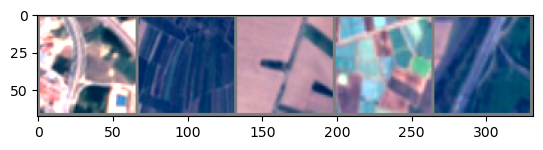

Predicted:  Highway  PermanentCrop  AnnualCrop  PermanentCrop  Highway 
Actual:     Highway  PermanentCrop  AnnualCrop  PermanentCrop  Highway 


In [25]:

# List of classes from the dataset
classes = dataset.classes

# Function to display an image 
def imshow(img):
    img = img.cpu() / 2 + 0.5  # Move the image to CPU and unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))



# Pass the images through the model to get outputs
outputs = model(images)

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Move the images back to the CPU for displaying
images_cpu = images.cpu()

# Select a random subset of images to display
num_images_to_display = 5
random_indices = random.sample(range(len(images_cpu)), num_images_to_display)

# Extract the random images and their corresponding labels
random_images = images_cpu[random_indices]
random_predicted_labels = predicted[random_indices]
random_actual_labels = labels[random_indices]

# Display the randomly selected images
imshow(torchvision.utils.make_grid(random_images))

# Print the predicted classes for the selected images
print('Predicted: ', ' '.join('%5s ' % classes[random_predicted_labels[j]] for j in range(num_images_to_display)))

# Print the actual classes for the selected images
print('Actual:    ', ' '.join('%5s ' % classes[random_actual_labels[j]] for j in range(num_images_to_display)))


Predicted all correctly.

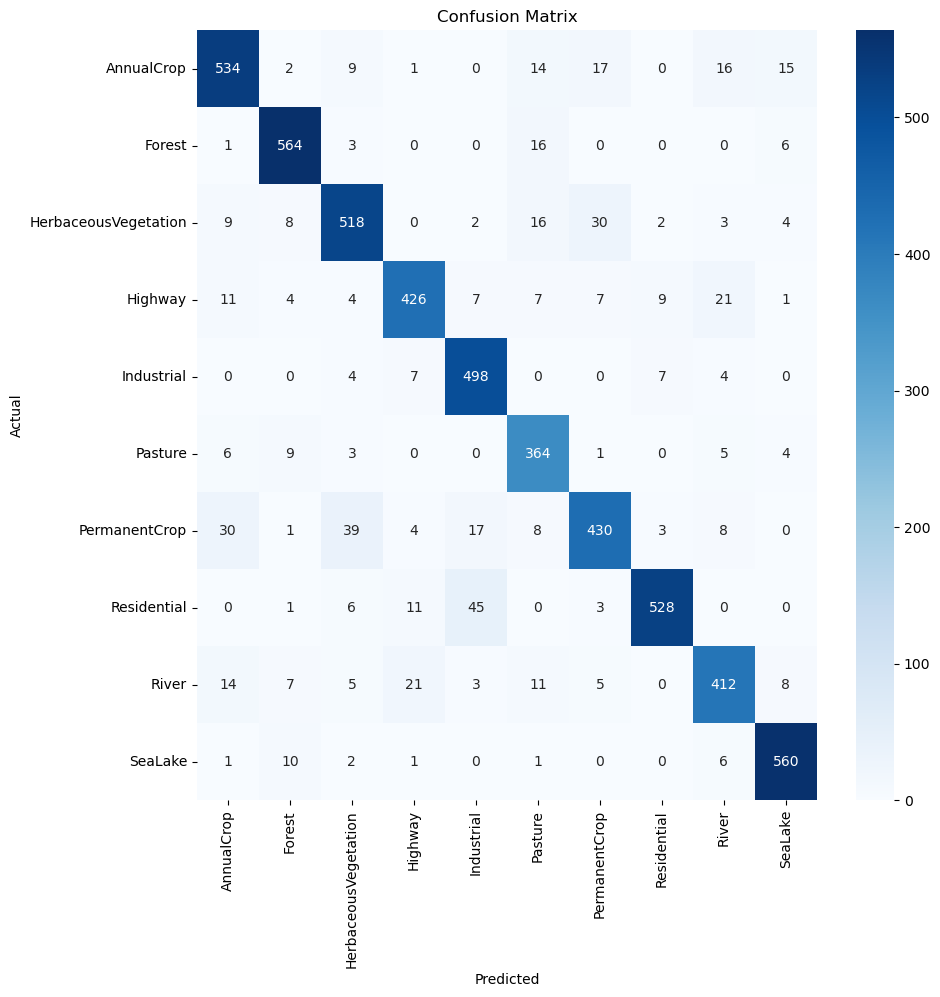

In [26]:

# Compute the confusion matrix based on all labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Summary:

Test Performance:

The test-set accuracies were recorded for each model:
NN Model 1: 83.35%
NN Model 2: 80.35%
ResNet18: 89.52%
These results indicate that the ResNet18 model, with its deeper architecture, generalizes better to unseen data compared to the other NN models.

Layer Summary:

NN Model 1 has a substantial number of trainable parameters, reflecting its moderate complexity. The ResNet18, being more complex, contains even more parameters, which contribute to its superior performance on the test set.

Insights:

The models show strong performance overall, particularly the ResNet18 model, which outperforms the other NNs. Despite this, there is still room for improvement, especially in reducing misclassifications. The ResNet18’s higher test accuracy suggests that deeper models with more layers might be more effective for this task. Further hyperparameter tuning and potentially increasing the dataset size could help in achieving even better generalization and reducing overfitting, as indicated by the difference between training and test performance.

Comparison of Model Performance:

ResNet18 outperforms the CNN model in predicting nearly all classes. However, the CNN performs better in predicting Residential, River, and SeaLake. These exceptions highlight where the CNN has an edge over ResNet18.